## About
This notebook quantifies agreement between IDPFold and the Schuler smFRET sequences reported by Holla et al.

IDPFold generates ensembles in two modes `all_delta` and `minus_1`. At least at the time at which these ensembles were generated it was not clear what the difference between these were (and still isn't), so we did both.

## Required code
In addition to STARLING, this notebook uses [SOURSOP](https://soursop.readthedocs.io/en/latest/), our IDP-specific simulation analysis package. We use this to calculate the radius of gyration ($R_g$) associated with the IDPFold ensembles.

SOURSOP can be installed using

    pip install soursop

Or check out the [installation guide here](https://soursop.readthedocs.io/en/latest/usage/installation.html).


#### References
Holla, A., Martin, E. W., Dannenhoffer-Lafage, T., Ruff, K. M., König, S. L. B., Nüesch, M. F., Chowdhury, A., Louis, J. M., Soranno, A., Nettels, D., Pappu, R. V., Best, R. B., Mittag, T. & Schuler, B. Identifying sequence effects on chain dimensions of disordered proteins by integrating experiments and simulations. JACS Au 4, 4729–4743 (2024).
  


In [7]:
import numpy as np
import matplotlib
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import matplotlib as mpl

mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from afrc import AnalyticalFRC
from sparrow import Protein
from shephard import interfaces, apis

from scipy.signal import savgol_filter
import metapredict as meta
from sparrow.data.amino_acids import VALID_AMINO_ACIDS
import pandas as pd
from scipy.stats import spearmanr
from soursop.sstrajectory import SSTrajectory
from starling import load_ensemble
from tqdm.auto import tqdm

# we define this location to load in the .starling ensembles so we don't have to reproduce them
SCHULER_ROOT = '../../../experimental_comparison/schuler_linkers/'

In [8]:
import numpy as np

def concordance_correlation_coefficient(y_true, y_pred):
    # Calculate means
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # Calculate variances
    var_true = np.var(y_true, ddof=0)
    var_pred = np.var(y_pred, ddof=0)
    
    # Calculate covariance
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    
    # Numerator and denominator of CCC
    numerator = 2 * covariance
    denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
    
    # Compute CCC
    ccc = numerator / denominator
    return ccc



In [9]:
from sparrow import Protein
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import protfasta

from scipy.stats import spearmanr


def calc_rmse(d1,d2):    
    """
    Function that given two lists or vectors, calculates the root-mean-square error (RMSE)
    between the two input datasets. Assumes both are the same length
    
    Parameters
    -------------
    d1 : list/vector/np.ndarray
        Dataset 1

    d2 : list/vector/np.ndarray
        Dataset 2
        
    Returns
    -------------
    float
        Returns a float which is the RMSE between the two datasets
        

    """
    
    return np.sqrt(np.mean(np.power(np.array(d1) - np.array(d2),2)))

# define the sequences
seqs = {}
seqs['sGrich']    = 'GSGSCSGGYGSERGGGYGSERGGGYGSERGGGYGSERGGGYGSQRSGGGYGGSQRSSYGSGSCTLGPR'
seqs['dKh']       = 'GSGSCAMGGGPGPGTDFTSDQADFPDTLFQEFEPPAPRPGLAGGRPGDAALLSAAYGRRRLLCTLGPR'
seqs['dGrich']    = 'GSGSCGPRTGLEGAGMAGGSGQQKRVFDGQSGPQDLGEAYRPLNHDGGDGGNRYSVIDRIQECTLGPR'
seqs['sPTBP']     = 'GSGSCRPDLPSGDSQPSLDQTMAAAFGLSVPNVHGALAPLAIPSAAAAAAAAGRIAIPGLAGCTLGPR'
seqs['sCh']       = 'GSGSCKKAQPEMNDKDDNESGNEDAEENHDDEEDENEEEDRQVDQASKNKESKRKAQNKREDCTLGPR'
seqs['sNrich']    = 'GSGSCLDQEDNNGPLLIKTANNLIQNNSNMLPLNALHNAPPMHLNEGGISNMRVNDSLPSNTCTLGPR'
seqs['sKh']       = 'GSGSCKPRRLSKLRRSKKPADEENNAASQDPTVEATQERGQASEDPENAANNAKQAKPTSDDCTLGPR'
seqs['dCh_plus']  = 'GSGSCQTPLKRIKVKTPGKSGAAAREGSVVSGTDGPTQTGKPERRKRLNPPKDKLIDMDDADCTLGPR'
seqs['dCh_minus'] = 'GSGSCMGLPTGMEEKEEGTDESEQKPVVQTPAQPDDSAEVDSAALDQAESAKQQGPILTKHGCTLGPR'
seqs['sKl']       = 'GSGSCAPEGVFKLPAPPKEIKKSEKSEKSSDSSNDKKEVESTTKTAATTTTTKKGTDNNTQFCTLGPR'
seqs['sNh_plus']  = 'GSGSCPEEIETRKKDRKNRREMLKRTSALQPAAPKPTHKKPVPKRNVGAERKSTINEDLLPPCTLGPR'
seqs['dArich']    = 'GSGSCLPTGAEGRDSSKGEDSAEETEAKPAVVAPAPVVEAVSTPSAAFPSDATAEQGPILTKCTLGPR'
seqs['dErich']    = 'GSGSCEGEMFGVMCEENSVVLSVEQPAELKEVADVSPPPTTRNHTIEMKPPLSAQQSECNPVCTLGPR'
seqs['dTRBP']     = 'GSGSCLEPALEDSSSFSPLDSSLPEDIPVFTAAAAATPVPSVVLTRSPPMELQPPVSPQQSECTLGPR'
seqs['dKl']       = 'GSGSCLPTGMDQKTTELMKVDEPVSTQETLPPVIKMEPEPVPITETPTDENARQQGPILTKHCTLGPR'
seqs['sNh_minus'] = 'GSGSCKKKLQDTPSEPMEKDPAEPETVPDGETPEDENPTEEGADNSSAKMEEEEEEEEEEEECTLGPR'

# define colors as used by Holla et al.
schuler_colors = {}
schuler_colors['sGrich'] = '#989898'
schuler_colors['dKh'] = '#AE8150'
schuler_colors['dGrich'] = '#989833'
schuler_colors['sPTBP'] = '#429797'
schuler_colors['sCh'] = '#BBFECE'
schuler_colors['sNrich'] = '#C9F73D'
schuler_colors['sKh'] = '#333391'
schuler_colors['dCh_plus'] = '#7187DE'
schuler_colors['dCh_minus'] = '#69F2F1'
schuler_colors['sNh_plus'] = '#EACBFE'
schuler_colors['sKl'] = '#A64BC2'
schuler_colors['dArich'] = '#F25AEA'
schuler_colors['dErich'] = '#FBCBCB'
schuler_colors['dTRBP'] = '#EA476F'
schuler_colors['dKl'] = '#F69A5A'
schuler_colors['sNh_minus'] = '#FEE648'

# define experimental data from paper
all_new_vals = {
    "sGrich": {"re": 4.0, "nu": 0.47},
    "dKh": {"re": 4.7, "nu": 0.51},
    "dGrich": {"re": 5.1, "nu": 0.53},
    "sPTBP": {"re": 5.5, "nu": 0.55},
    "sCh": {"re": 5.7, "nu": 0.56},
    "sNrich": {"re": 5.9, "nu": 0.56},
    "sKh": {"re": 5.9, "nu": 0.57},
    "dCh_plus": {"re": 5.9, "nu": 0.57},
    "dCh_minus": {"re": 6.7, "nu": 0.59},
    "sKl": {"re": 6.7, "nu": 0.59},
    "sNh_plus": {"re": 6.7, "nu": 0.59},    
    "dArich": {"re": 6.8, "nu": 0.60},
    "dErich": {"re": 6.9, "nu": 0.60},
    "dTRBP": {"re": 7.1, "nu": 0.61},
    "dKl": {"re": 7.2, "nu": 0.61},
    "sNh_minus": {"re": 7.3, "nu": 0.61}
}

# extract out Re
new_vals = {}
for k in all_new_vals: 
    new_vals[k] = all_new_vals[k]['re']

In [10]:
## Note: this cell will load in 2 sets of PDB-based ensembles using SOURSOP, and will
##       take maybe 2 minutes or so to run.
# Specify the directory containing the .pdb files for the IDPFold ensembles
SCHULER_IDPFOLD_DIR = '../idpfold_ensembles/'

# Loop through all files in the directory - we look at BOTH the all_delta and minus_1 ensembles. 
IDPFold_ensembles_all_delta = {}
IDPFold_ensembles_min1 = {}
STARLING_ensembles = {}

sequences = {}
directory = f'{SCHULER_IDPFOLD_DIR}/all_delta'
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".pdb"):
        seqname = filename.split('.')[0]

        # read STARLING ensemble in 
        STARLING_ensembles[seqname] = load_ensemble(f'{SCHULER_ROOT}/ensembles/{seqname}.starling')
        
        filepath = os.path.join(directory, filename)
        IDPFold_ensembles_all_delta[seqname] = SSTrajectory(filepath, filepath).proteinTrajectoryList[0]
        sequences[seqname] = STARLING_ensembles[seqname].sequence

directory = f'{SCHULER_IDPFOLD_DIR}/minus_1'
for filename in tqdm(os.listdir(directory)):       
    if filename.endswith(".pdb"):
        seqname = filename.split('.')[0]
        filepath = os.path.join(directory, filename)
        IDPFold_ensembles_min1[seqname] = SSTrajectory(filepath, filepath).proteinTrajectoryList[0]
        
    
        

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [11]:
starling_ensembles = {}
starling_res = {}
starling_rgs = {}
starling_res_all = {}
starling_rgs_all = {}

idpfold_res_all_delta = {}
idpfold_res_min1 = {}
idpfold_rgs_all_delta = {}

fret_values = []
for k in seqs:
    e = load_ensemble(f'{SCHULER_ROOT}/ensembles/{k}.starling')
    starling_res[k] = e.end_to_end_distance(return_mean=True)
    starling_rgs[k] = e.radius_of_gyration(return_mean=True)
    starling_res_all[k] = e.end_to_end_distance()
    starling_rgs_all[k] = e.radius_of_gyration()
    fret_values.append(all_new_vals[k]['re']*10)
    
    idpfold_res_all_delta[k] = IDPFold_ensembles_all_delta[k].get_end_to_end_distance()
    idpfold_res_min1[k] = IDPFold_ensembles_min1[k].get_end_to_end_distance()
    idpfold_rgs_all_delta[k] = IDPFold_ensembles_all_delta[k].get_radius_of_gyration()

fret_values = np.array(fret_values)
starling_mean_rg = np.array(list(starling_rgs.values()))
starling_mean_re = np.array(list(starling_res.values()))

idpfold_mean_re  = [np.mean(idpfold_res_all_delta[k]) for k in idpfold_res_all_delta]
idpfold_mean_rg  = [np.mean(idpfold_rgs_all_delta[k]) for k in idpfold_rgs_all_delta]


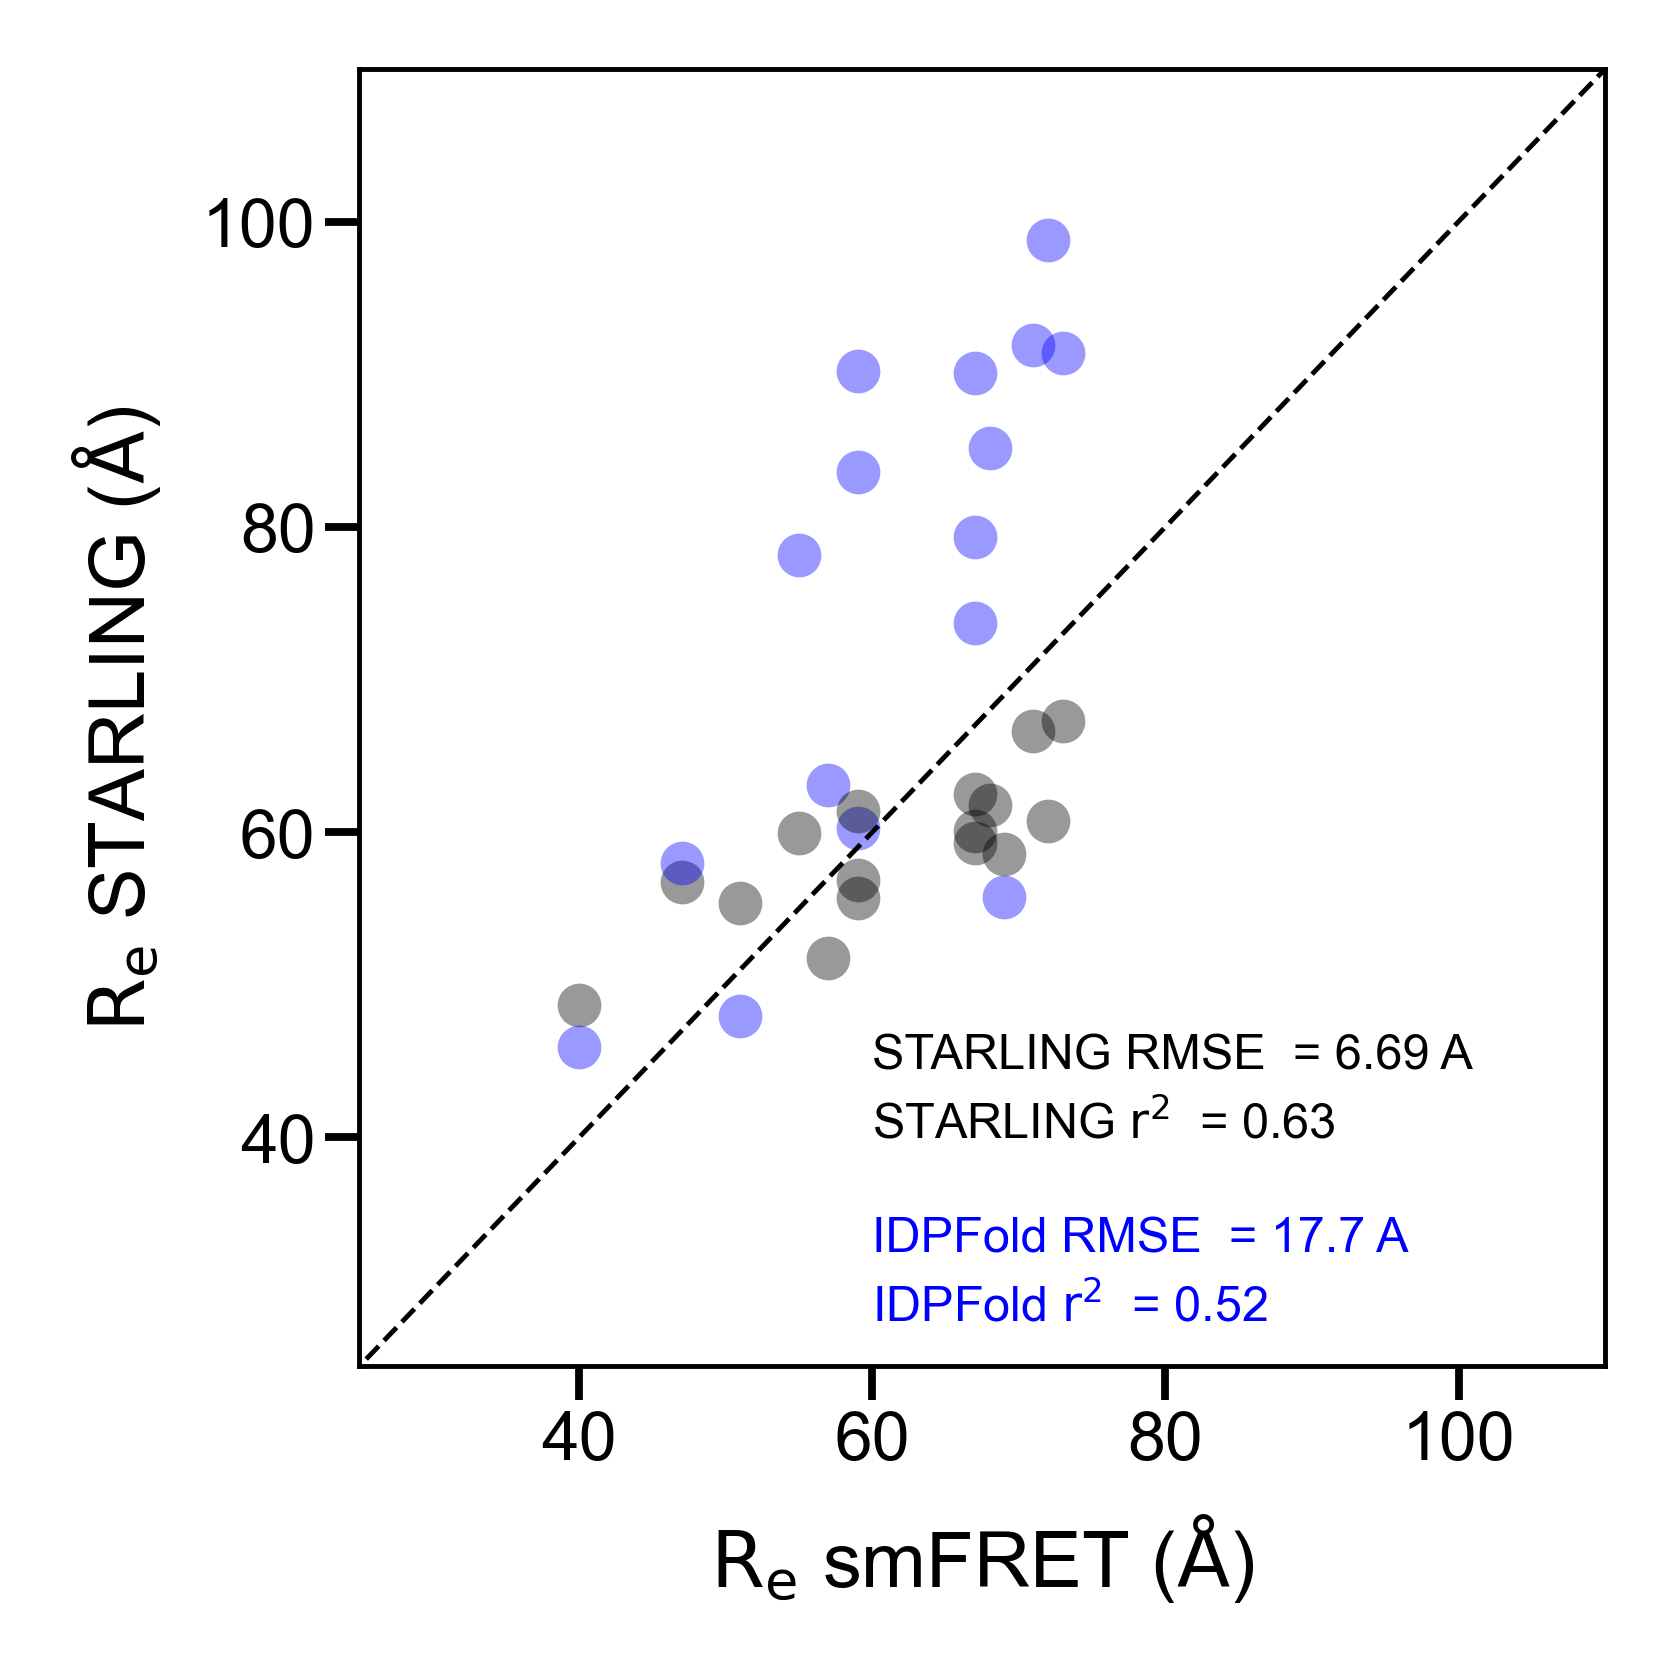

In [12]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

for i, k in enumerate(all_new_vals):
    #plt.plot(fret_values[i], starling_mean_re[i], 'o', color=schuler_colors[k], ms=4.5, mew=0.4, alpha=0.8, mec='k', label='STARLING')
    plt.plot(fret_values[i], starling_mean_re[i], 'o', color='k', ms=4.5, mew=0.0, alpha=0.4, mec='k', label='STARLING')
    plt.plot(fret_values[i], idpfold_mean_re[i], 'o', color='b', ms=4.5, mew=0.0, alpha=0.4, mec='k', label='IDPFold-all-delta')

plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)


starling_r2 = np.power(np.corrcoef(fret_values, starling_mean_re)[0][1],2)
starling_rmse = calc_rmse(fret_values,starling_mean_re)

idpfold_r2 = np.power(np.corrcoef(fret_values, idpfold_mean_re)[0][1],2)
idpfold_rmse = calc_rmse(fret_values,idpfold_mean_re)


plt.text(60, 44.5, r"STARLING RMSE " +f" = {round(starling_rmse,2)} A", fontsize=5)
plt.text(60, 40, r"STARLING $\rm{r^2}$ " +f" = {round(starling_r2,2)}", fontsize=5)

plt.text(60, 32.5, r"IDPFold RMSE " +f" = {round(idpfold_rmse,2)} A", fontsize=5, color='b')
plt.text(60, 28, r"IDPFold $\rm{r^2}$ " +f" = {round(idpfold_r2,2)}", fontsize=5, color='b')


plt.xlabel(r'$\rm{R_e}$ smFRET ($\rm\AA$)', fontsize=8)
plt.ylabel(r'$\rm{R_e}$ STARLING ($\rm\AA$)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.ylim([25,110])
plt.xlim([25,110])

plt.tight_layout()
plt.savefig('figures/schuler_idpfold_starling_vs_smFRET.pdf')



# Plot distribution vs. actual value

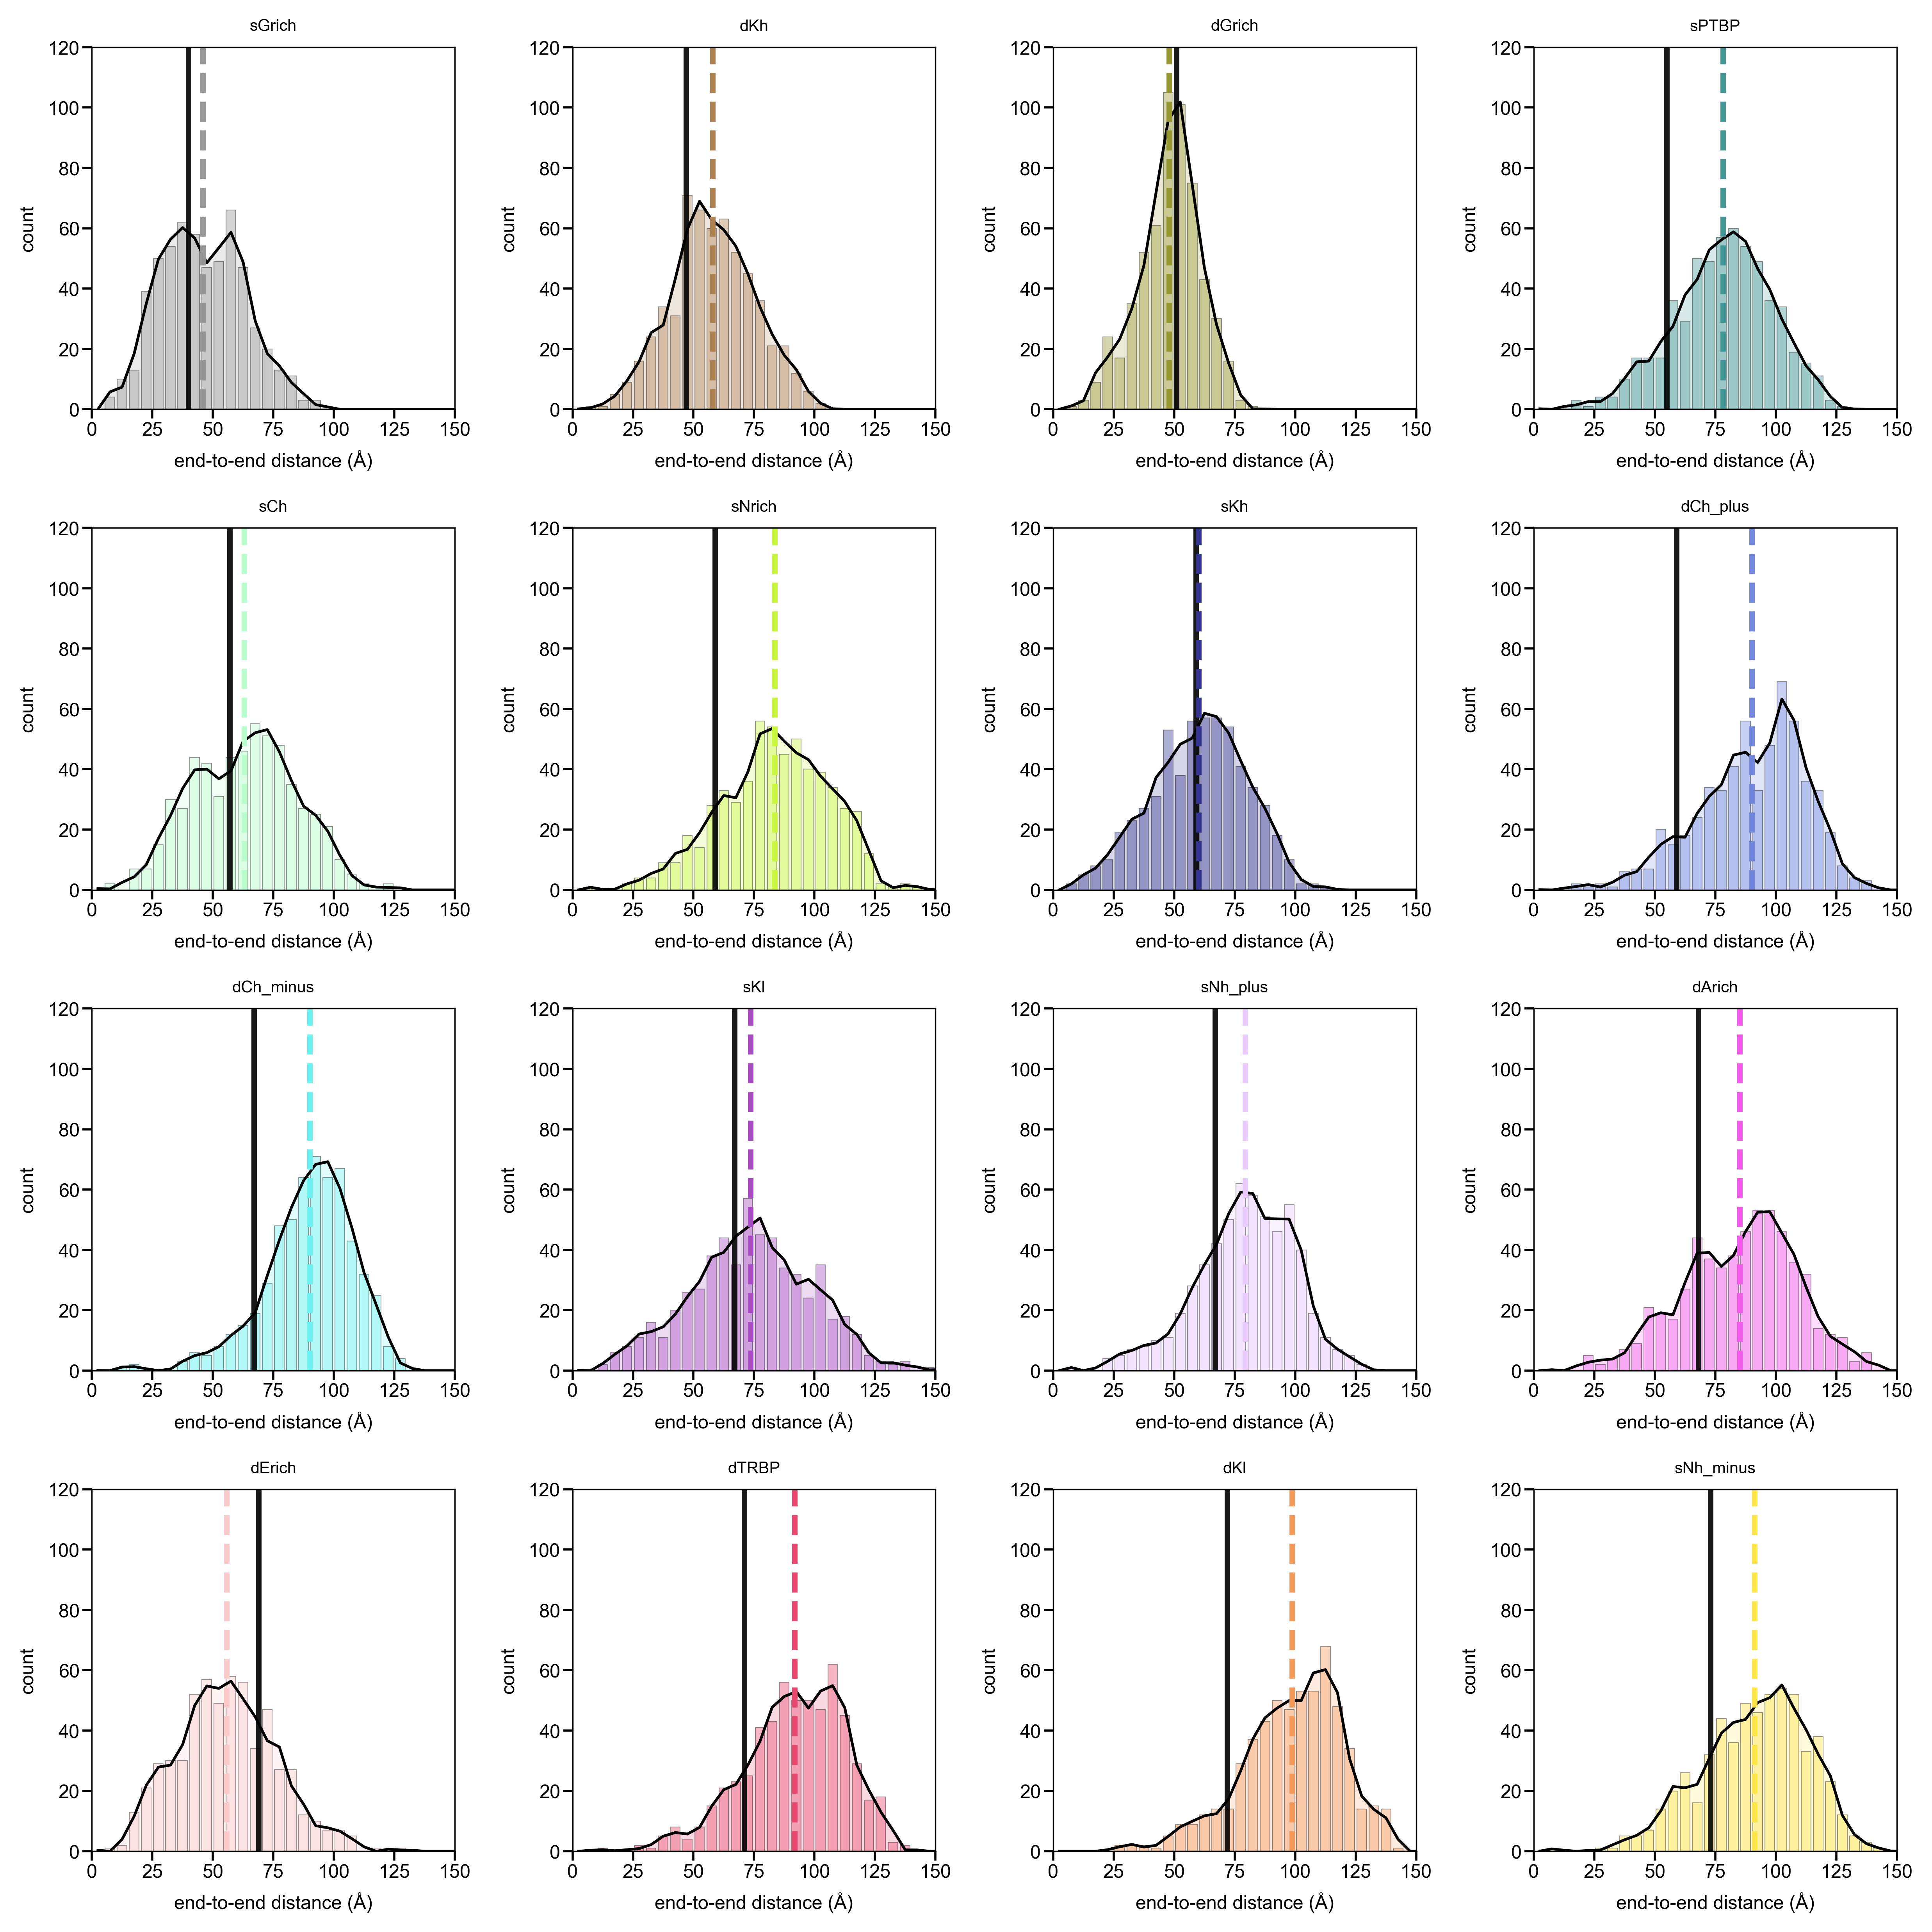

In [13]:
def get_histogram_vals(vals, bw=5, bmin=0, bmax=200, wl=5, polyorder=3):
    bins = np.arange(bmin, bmax, bw)
    a, b = np.histogram(vals, bins=bins)
    smoothed = savgol_filter(a, wl, polyorder)
    smoothed[smoothed < 0] = 0
    return b[1:] - bw * 0.5, a, smoothed

def plot_all_histograms(starling_res_all, new_vals, schuler_colors):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10), dpi=250)
    axes = axes.flatten()
    
    for i, (n, ax) in enumerate(zip(starling_res_all.keys(), axes)):
        bw=5
        X = get_histogram_vals(idpfold_res_all_delta[n], bw=bw)
        
        ax.plot(X[0], X[2], color='k', lw=1)
        ax.fill_between(X[0], 0, X[2], alpha=0.2, color=schuler_colors[n])
        ax.bar(X[0], X[1], width=bw * 0.8, color=schuler_colors[n], alpha=0.4, edgecolor='k', lw=0.3)
        ax.set_ylim([0, 120])
        ax.set_xlim([0, 150])
        ax.tick_params(axis='both', labelsize=7)
        ax.set_ylabel('count', fontsize=7)
        ax.set_xlabel('end-to-end distance (Å)', fontsize=7)
        ax.set_title(n, fontsize=6)
        ax.axvline(new_vals[n] * 10, color='k', lw=2, alpha=0.9)
        ax.axvline(np.mean(idpfold_res_all_delta[n]), color=schuler_colors[n], lw=2, alpha=1, ls='--')
    
    # Remove unused subplots if less than 16 datasets
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('figures/schuler_vs_idpfold_all_histograms.pdf')
    plt.show()

# Call the function
plot_all_histograms(starling_res_all, new_vals, schuler_colors)


In [14]:
diffs = []
for n in starling_res_all:    
    diffs.append(np.mean(starling_res_all[n]) - new_vals[n]*10)
    
RMSE = np.sqrt(np.mean(np.power(diffs,2)))
print(f"RMSE: {round(RMSE,2)} Å")

RMSE: 6.690000057220459 Å


In [15]:
diffs = []
for n in idpfold_res_all_delta:    
    diffs.append(np.mean(idpfold_res_all_delta[n]) - new_vals[n]*10)
    
RMSE = np.sqrt(np.mean(np.power(diffs,2)))
print(f"RMSE: {round(RMSE,2)} Å")

RMSE: 17.7 Å
